In [1]:
from dateutil.relativedelta import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 7]
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [4]:
catalog = pd.read_csv("../helper/catalog.csv")
data = pd.read_csv("../output/2020-06-01_database_tf.csv", parse_dates=["date"])
ys = ["x_world.sa", "x_vol_world2.sa", "x_servs_world.sa"]

In [36]:
# generating vintage dataset
def offset_series(series, offset):
    tmp = series
    tmp[-offset:] = np.nan
    return tmp
    
def gen_vintage(data, catalog, start_date, end_date):
    tmp = data.loc[lambda x: (x.date >= start_date) & (x.date <= end_date), :]
    offsets = [
        catalog.loc[catalog.code == x,"publication_lag"].values[0]
            if len(catalog.loc[catalog.code == x,"publication_lag"]) > 0 
            else catalog.loc[catalog.code == x[:-3],"publication_lag"].values[0]
        for x in data.columns[1:]
    ]
    for i in range(1, len(tmp.columns)):
        tmp.iloc[:,i] = offset_series(tmp.iloc[:,i], offsets[i-1])
    return tmp

def gen_target_data(data, catalog, target, start_date, end_date):
    vintage = gen_vintage(data, catalog, start_date, end_date)
    if target == "x_world.sa":
        catalog_col = "octave_value"
    elif target == "x_vol_world2.sa":
        catalog_col = "octave_volume"
    elif target == "x_servs_world.sa":
        catalog_col = "octave_services"
    #tmp = vintage.loc[:, pd.unique(["date"] + catalog.loc[~pd.isna(catalog[catalog_col]), catalog_col].to_list())].interpolate()
    tmp = vintage.loc[:, pd.unique(["date"] + catalog.loc[~pd.isna(catalog[catalog_col]), catalog_col].to_list())]
    tmp = gen_vintage(tmp, catalog, start_date, end_date).set_index("date").dropna(how="all")
    return tmp

# Running model vintage

In [39]:
# params
start_date = "2002-01-01"
global_end_date = "2020-06-01"
target = "x_world.sa"
model_num = "model_3"
    
end_date = pd.to_datetime("2018-01-01")
results = pd.DataFrame({"date": pd.date_range(end_date, global_end_date, freq="MS")})
for col in ["actual", "+3", "+2", "+1", "0", "-1", "-2"]:
    results[col] = np.nan

while end_date <= pd.to_datetime(global_end_date):
    print(end_date)
    
    # model
    x = gen_target_data(data, catalog, target, start_date, end_date)
    mod = sm.tsa.DynamicFactor(x, k_factors=1, factor_order=1, error_order=1)
    initial_res = mod.fit(method='powell', disp=False)
    res = mod.fit(initial_res.params, disp=False)
    res = mod.fit(disp=False)
    pred = res.predict().append(res.forecast(5))
    
    results.loc[results.date == (end_date + relativedelta(months = -1)), "+1"] = pred.loc[pred.index == (end_date + relativedelta(months = -1)), target].values[0]
    results.loc[results.date == (end_date + relativedelta(months = -2)), "+2"] = pred.loc[pred.index == (end_date + relativedelta(months = -2)), target].values[0]
    results.loc[results.date == (end_date + relativedelta(months = -3)), "+3"] = pred.loc[pred.index == (end_date + relativedelta(months = -3)), target].values[0]
    results.loc[results.date == end_date, "0"] = pred.loc[pred.index == end_date, target].values[0]
    results.loc[results.date == (end_date + relativedelta(months = +1)), "-1"] = pred.loc[pred.index == (end_date + relativedelta(months = +1)), target].values[0]
    results.loc[results.date == (end_date + relativedelta(months = +2)), "-2"] = pred.loc[pred.index == (end_date + relativedelta(months = +2)), target].values[0]
    
    end_date += relativedelta(months = +1)
    
results = results.merge(data.loc[:, ["date", target]], how="left", on ="date")
results.actual = results[target]
results = results.drop([target], axis=1)

results.to_csv(f"python_dfm_results/{model_num}.csv", index=False)

2018-01-01 00:00:00
2018-02-01 00:00:00
2018-03-01 00:00:00
2018-04-01 00:00:00
2018-05-01 00:00:00
2018-06-01 00:00:00
2018-07-01 00:00:00
2018-08-01 00:00:00
2018-09-01 00:00:00
2018-10-01 00:00:00
2018-11-01 00:00:00
2018-12-01 00:00:00
2019-01-01 00:00:00
2019-02-01 00:00:00
2019-03-01 00:00:00
2019-04-01 00:00:00
2019-05-01 00:00:00
2019-06-01 00:00:00
2019-07-01 00:00:00
2019-08-01 00:00:00
2019-09-01 00:00:00
2019-10-01 00:00:00
2019-11-01 00:00:00
2019-12-01 00:00:00
2020-01-01 00:00:00
2020-02-01 00:00:00
2020-03-01 00:00:00
2020-04-01 00:00:00
2020-05-01 00:00:00
2020-06-01 00:00:00


# Model 1

+3 MAE: 0.0036
+2 MAE: 0.01101
+1 MAE: 0.00948
0 MAE: 0.011
-1 MAE: 0.01228
-2 MAE: 0.0122


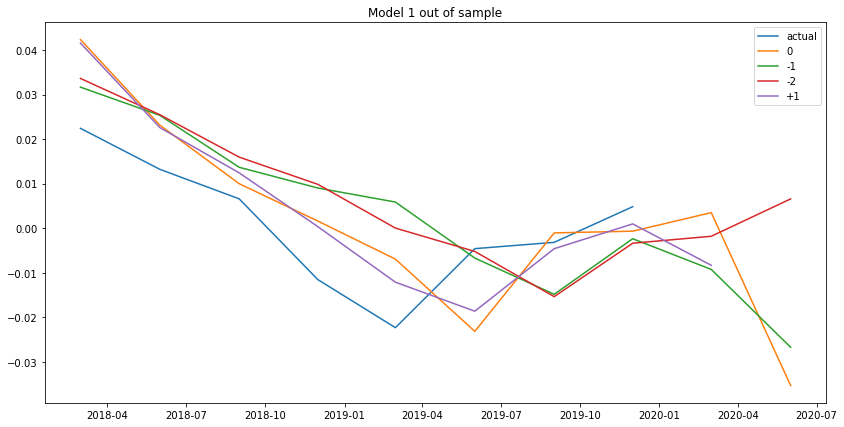

In [291]:
# plotting out of sample results
print(f"+3 MAE: {np.mean(np.abs(results.actual - results['+3'])).round(5)}")
print(f"+2 MAE: {np.mean(np.abs(results.actual - results['+2'])).round(5)}")
print(f"+1 MAE: {np.mean(np.abs(results.actual - results['+1'])).round(5)}")
print(f"0 MAE: {np.mean(np.abs(results.actual - results['0'])).round(5)}")
print(f"-1 MAE: {np.mean(np.abs(results.actual - results['-1'])).round(5)}")
print(f"-2 MAE: {np.mean(np.abs(results.actual - results['-2'])).round(5)}")

tmp = results
tmp = tmp.loc[(~pd.isna(tmp.actual)) | (tmp.date == "2020-03-01") | (tmp.date == "2020-06-01"),:].reset_index(drop=True)
plt.plot(tmp.date, tmp.actual, label="actual")
plt.plot(tmp.date, tmp["0"], label="0")
plt.plot(tmp.date, tmp["-1"], label="-1")
plt.plot(tmp.date, tmp["-2"], label="-2")
plt.plot(tmp.date, tmp["+1"], label="+1")
# plt.plot(tmp.date, tmp["+2"], label="+2")
# plt.plot(tmp.date, tmp["+3"], label="+3")
plt.title("Model 1 out of sample")
plt.legend();

MAE: 0.01064


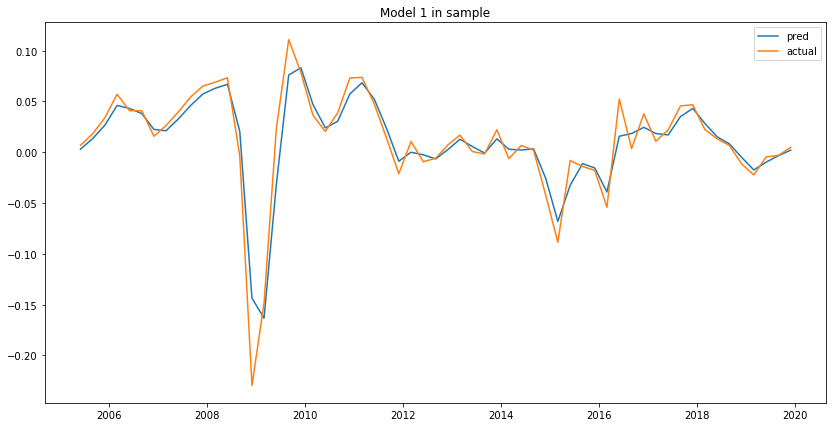

In [319]:
# plotting in sample results
x = gen_target_data(data, catalog, target, "2002-01-01", "2020-06-01")
mod = sm.tsa.DynamicFactor(x, k_factors=1, factor_order=1, error_order=1)
initial_res = mod.fit(method='powell', disp=False)
res = mod.fit(initial_res.params, disp=False)
pred = res.predict().append(res.forecast(5))

tmp = pred["x_world.sa"].reset_index().merge(data.loc[:,["date", "x_world.sa"]], how="left", left_on="index", right_on="date").drop("index", axis=1)
tmp.columns = ["pred", "date", "actual"]
tmp = tmp.loc[~pd.isna(tmp.actual), :].reset_index(drop=True)

print(f"MAE: {np.mean(np.abs(tmp.pred - tmp.actual)).round(5)}")

plt.plot(tmp.date, tmp.pred, label="pred")
plt.plot(tmp.date, tmp.actual, label="actual")
plt.title("Model 1 in sample")
plt.legend();

In [332]:
res.predict().append(res.forecast()).reset_index()[["index", "x_world.sa"]].to_csv("/home/danhopp/Downloads/data.csv")

# Model 2

+3 MAE: 0.00415
+2 MAE: 0.00996
+1 MAE: 0.01071
0 MAE: 0.02343
-1 MAE: 0.01378
-2 MAE: 0.01329


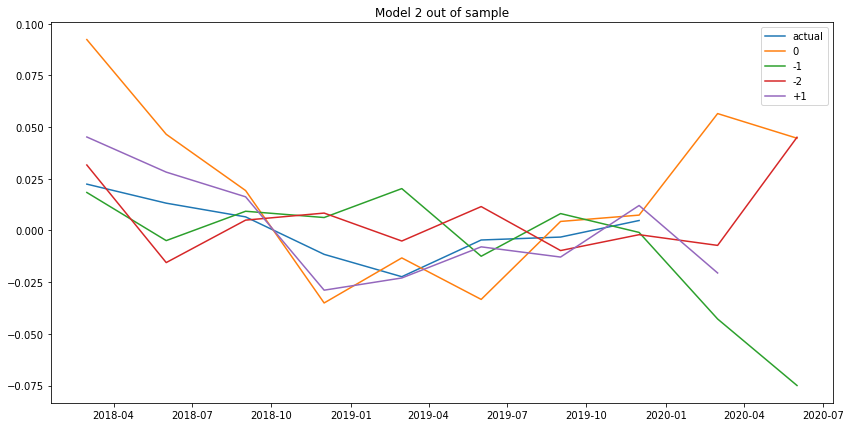

In [305]:
# plotting out of sample results
print(f"+3 MAE: {np.mean(np.abs(results.actual - results['+3'])).round(5)}")
print(f"+2 MAE: {np.mean(np.abs(results.actual - results['+2'])).round(5)}")
print(f"+1 MAE: {np.mean(np.abs(results.actual - results['+1'])).round(5)}")
print(f"0 MAE: {np.mean(np.abs(results.actual - results['0'])).round(5)}")
print(f"-1 MAE: {np.mean(np.abs(results.actual - results['-1'])).round(5)}")
print(f"-2 MAE: {np.mean(np.abs(results.actual - results['-2'])).round(5)}")

tmp = results
tmp = tmp.loc[(~pd.isna(tmp.actual)) | (tmp.date == "2020-03-01") | (tmp.date == "2020-06-01"),:].reset_index(drop=True)
plt.plot(tmp.date, tmp.actual, label="actual")
plt.plot(tmp.date, tmp["0"], label="0")
plt.plot(tmp.date, tmp["-1"], label="-1")
plt.plot(tmp.date, tmp["-2"], label="-2")
plt.plot(tmp.date, tmp["+1"], label="+1")
# plt.plot(tmp.date, tmp["+2"], label="+2")
# plt.plot(tmp.date, tmp["+3"], label="+3")
plt.title("Model 2 out of sample")
plt.legend();

MAE: 0.01485


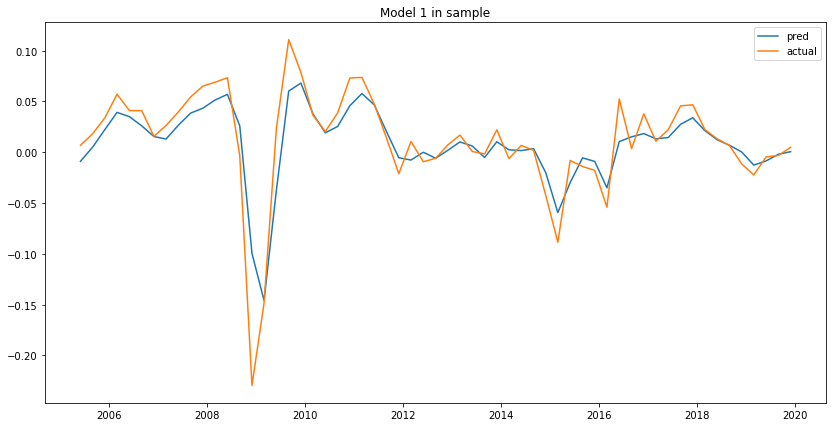

In [317]:
# plotting in sample results
x = gen_target_data(data, catalog, target, "2002-01-01", "2020-04-01")
mod = sm.tsa.DynamicFactor(x, k_factors=1, factor_order=1, error_order=1)
res = mod.fit(disp=False)
pred = res.predict().append(res.forecast(5))

tmp = pred["x_world.sa"].reset_index().merge(data.loc[:,["date", "x_world.sa"]], how="left", left_on="index", right_on="date").drop("index", axis=1)
tmp.columns = ["pred", "date", "actual"]
tmp = tmp.loc[~pd.isna(tmp.actual), :].reset_index(drop=True)

print(f"MAE: {np.mean(np.abs(tmp.pred - tmp.actual)).round(5)}")

plt.plot(tmp.date, tmp.pred, label="pred")
plt.plot(tmp.date, tmp.actual, label="actual")
plt.title("Model 2 in sample")
plt.legend();

# Model 3

+3 MAE: 0.00617
+2 MAE: 0.00612
+1 MAE: 0.00601
0 MAE: 0.0114
-1 MAE: 0.01141
-2 MAE: 0.01313


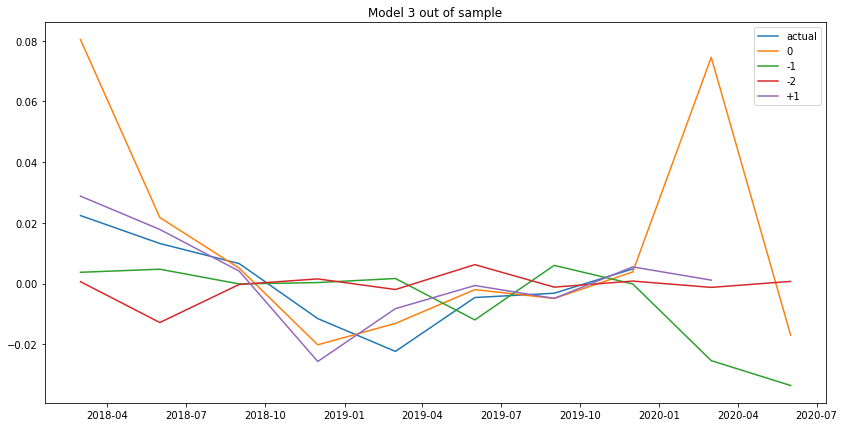

In [40]:
# plotting out of sample results
print(f"+3 MAE: {np.mean(np.abs(results.actual - results['+3'])).round(5)}")
print(f"+2 MAE: {np.mean(np.abs(results.actual - results['+2'])).round(5)}")
print(f"+1 MAE: {np.mean(np.abs(results.actual - results['+1'])).round(5)}")
print(f"0 MAE: {np.mean(np.abs(results.actual - results['0'])).round(5)}")
print(f"-1 MAE: {np.mean(np.abs(results.actual - results['-1'])).round(5)}")
print(f"-2 MAE: {np.mean(np.abs(results.actual - results['-2'])).round(5)}")

tmp = results
tmp = tmp.loc[(~pd.isna(tmp.actual)) | (tmp.date == "2020-03-01") | (tmp.date == "2020-06-01"),:].reset_index(drop=True)
plt.plot(tmp.date, tmp.actual, label="actual")
plt.plot(tmp.date, tmp["0"], label="0")
plt.plot(tmp.date, tmp["-1"], label="-1")
plt.plot(tmp.date, tmp["-2"], label="-2")
plt.plot(tmp.date, tmp["+1"], label="+1")
# plt.plot(tmp.date, tmp["+2"], label="+2")
# plt.plot(tmp.date, tmp["+3"], label="+3")
plt.title("Model 3 out of sample")
plt.legend();